In [1]:
import csv
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

from sklearn.cluster import KMeans, SpectralClustering
from sklearn.neighbors import NearestNeighbors
from itertools import chain

## Data Ingestion

In [2]:
filename: str = "../input.csv"
data = []
with open(filename, "r") as input_file:
    csv_reader = csv.reader(input_file, delimiter=',')
    for line in csv_reader:
        data.append(tuple(int(x) for x in line))


## Configuration

In [3]:
# number of representative points to pick from the input data
NUM_REPS = 10

## k-Means Clustering

In [4]:
kmeans = KMeans(
    n_clusters=NUM_REPS,
    init='random', 
    n_init=50,
    max_iter=300
)
kmeans.fit(data)
kmeans_centroids = kmeans.cluster_centers_

## 1-NN to Centroids from Input Data

In [5]:
knn = NearestNeighbors(n_neighbors=1).fit(data)
kmeans_neighbors_idx = knn.kneighbors(kmeans_centroids, n_neighbors=1, return_distance=False)
kmeans_closest_points_set = set(data[x[0]] for x in kmeans_neighbors_idx)
kmeans_closest_points = list(kmeans_closest_points_set)
print(kmeans_closest_points)

[(6302, 6985), (3827, 6064), (7317, 6107), (2614, 6160), (7048, 4554), (4291, 3851), (5267, 3372), (2835, 4008), (6355, 5556), (9344, 8190)]


## Plotting

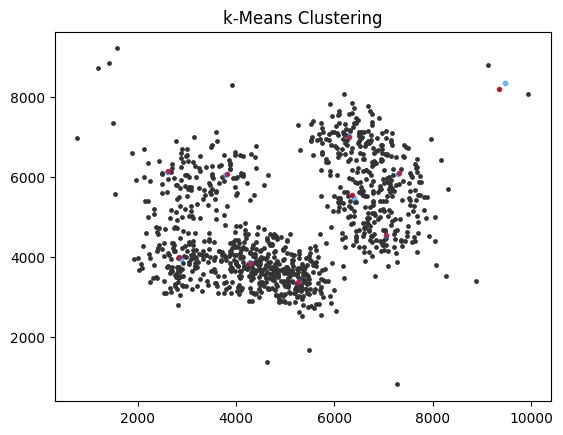

In [6]:
plt.scatter(
    [x[0] for x in data], 
    [y[1] for y in data], 
    s=6,
    color='#333333'
)

plt.scatter(
    [x[0] for x in kmeans_centroids], 
    [y[1] for y in kmeans_centroids], 
    s=10,
    color='#0784f97f'
)

plt.scatter(
    [x[0] for x in kmeans_closest_points], 
    [y[1] for y in kmeans_closest_points], 
    s=10,
    color='#fc052e7f'
)
plt.title("k-Means Clustering")
plt.show()

## Analysis

In [7]:
def point_distance(a: tuple[int, int], b: tuple[int, int]) -> float:
    """Return the Euclidean distance between two 2D input points."""
    return ((b[0] - a[0])**2 + (b[1] - a[1])**2)**(1/2)

### Native Total Distance

In [8]:
distance_sum = 0
for i in data:
    for j in kmeans_closest_points:
        distance_sum += point_distance(i, j)
print(distance_sum)

29337262.85098485


### k-Neighbors Distance
for `k = 6` (7 in practice, to exclude the chosen rep point itself)

In [11]:
k = 6 + 1
knn = NearestNeighbors(n_neighbors=k).fit(data)

# dists = distances to the k-neighbors, for each selected point
dists, neighbors_idx = knn.kneighbors(kmeans_closest_points, n_neighbors=k, return_distance=True)
avg_dist_per_cluster = [sum(cluster)/len(cluster) for cluster in dists]
avg_dist_of_all_clusters = sum(avg_dist_per_cluster)/len(avg_dist_per_cluster)
print("Average distance from rep to nearest 6 data points:")
print(avg_dist_of_all_clusters)

Average distance from rep to nearest 6 data points:
242.2526578989015


### Distances to Closest Rep Points
Take all points not selected as a rep, find their closest rep,  compute their distance.

In [12]:
dists_to_closest_rep = []
for point in data:
    if point not in kmeans_closest_points_set:
        closest_rep = min(kmeans_closest_points_set, key=lambda rep: point_distance(point, rep))
        dists_to_closest_rep.append(point_distance(point, closest_rep))

print(f"Min distance to rep: {min(dists_to_closest_rep)}")
print(f"Max distance to rep: {max(dists_to_closest_rep)}")
print(f"Avg distance to rep: {sum(dists_to_closest_rep)/len(dists_to_closest_rep)}")

Min distance to rep: 29.68164415931166
Max distance to rep: 3246.6056120200374
Avg distance to rep: 530.8514169800166


### Closest Distance Between Reps

In [13]:
min_dist_between_reps = float('inf')
for i in kmeans_closest_points_set:
    for j in kmeans_closest_points_set:
        if i != j and (dist := point_distance(i, j)) < min_dist_between_reps:
            min_dist_between_reps = dist
print(min_dist_between_reps)


1087.2060522274514
